# Define the class DecisionMatrix

In [54]:
from typing import Dict, List, Optional, Union
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [55]:
from typing import Dict, List, Optional
import pandas as pd
import numpy as np
import copy

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mtick
import matplotlib.lines as mlines
import matplotlib.cm as cm

class DecisionMatrix:
    def __init__(
        self,
        metrics_df: pd.DataFrame,
        objectives: Dict[str, int],
        alt_cols: List[str],
        crit_cols: List[str],
        weights: Optional[Dict[str, float]] = None,
        group_cols: Optional[List[str]] = [],
        group_weights: Optional[Dict[str, float]] = None,
        unc_cols: Optional[List[str]] = [],
        crit_cats: Optional[Dict[str, List[str]]] = None
    ):
        """
        Initialize the DecisionMatrix object.

        Parameters:
        - metrics_df : pd.DataFrame
            DataFrame containing metrics data.
        - objectives : Dict[str, int]
            Dictionary mapping objectives to their values.
        - alt_cols : List[str]
            List of alternative columns.
        - crit_cols : List[str]
            List of criteria columns.
        - weights : Dict[str, float], optional
            Dictionary of criteria weights values. Defaults to an empty dictionary.
        - group_cols : List[str], optional
            List of group columns. Defaults to an empty list.
        - group_weights : Dict[str, float], optional
            Dictionary of weights for group columns. Defaults to an empty dictionary.
        - unc_cols : List[str], optional
            List of uncertainty columns. Defaults to an empty list.
        - crit_cats : Dict[str, List[str]], optional
            Dictionary of categorized criteria. Defaults to an empty dictionary.
        """
        
        # Assign input parameters to class attributes as copies
        self.metrics_df = metrics_df.copy()
        self.objectives = copy.deepcopy(objectives)
        self.alt_cols = alt_cols.copy()
        self.crit_cols = crit_cols.copy()
        self.weights = weights.copy() if weights is not None else {}
        self.group_cols = group_cols.copy() if group_cols is not None else []
        self.group_weights = group_weights.copy() if group_weights is not None else {}
        self.unc_cols = unc_cols.copy() if unc_cols is not None else []
        self.crit_cats = crit_cats.copy() if crit_cats is not None else {}

        # Initialize dataframes – Attributes to store dataframes used for calculations and organization
        self._initialize_dataframes()

        # Process initial data
        self._process_initial_data()


    # Method to initialize dataframes
    def _initialize_dataframes(self):
        self.dm_df = None # Decision matrix dataframe ( The main dataframe)
        self.alternatives_df = None # Alternatives dataframe (unique alternatives, their IDs
        self.crit_df = None # Criteria dataframe (criteria and their weights)
        self.cat_crit_df = None # Categorized criteria dataframe (criteria and their categories)
        self.groups_df = None # Groups dataframe (if group columns are provided, otherwise None)
        self.unc_smpls_df = None # Uncertainty samples dataframe (if uncertainty columns are provided, otherwise None)

    # Method to process initial data
    def _process_initial_data(self):
        self._sort_metrics_df()                # Sort metrics_df by alternative, group, and uncertainty columns for readability in the decision matrix
        self._validate_inputs()                # Validate inputs for duplicate rows based on alternative, group, and uncertainty columns
        self._calculate_weights()              # Calculate weights for criteria and group columns if not provided
        self._prepare_criteria_dataframes()    # Prepare criteria dataframes (criteria and categorized criteria)
        self._prepare_alternatives_dataframe() # Prepare alternatives dataframe (unique alternatives)
        self._prepare_decision_matrix_dataframe() # Prepare decision matrix dataframe by merging alternatives, groups, and uncertainty samples

    # Method to sort metrics dataframe
    def _sort_metrics_df(self):
        """
        Sort the metrics DataFrame by alternative, group, and uncertainty columns.
        Sorting by alternative, group, and uncertainty columns makes the decision matrix more readable.
        """
        self.metrics_df = self.metrics_df.sort_values(by=self.alt_cols + self.group_cols + self.unc_cols)

    # Method to validate inputs
    def _validate_inputs(self):
        """
        Validate the input DataFrame for duplicate rows based on alternative, group, and uncertainty columns.
        Each alternative could only have one unique combination of group and uncertainty columns.
        """
        if self.metrics_df.duplicated(subset=self.alt_cols + self.group_cols + self.unc_cols, keep=False).any():
            raise ValueError("Duplicated rows of alt_cols, group_cols, and sample. Some alternative IDs are counted more than once for some group ID and sample ID pairs.")

    # Method to calculate weights
    def _calculate_weights(self):
        """
        Calculate weights for criteria and group columns if not provided.

        This method performs the following main tasks:
        1. Assign equal weights to criteria if not provided.
        2. Calculate and assign weights to group members if group columns are specified.

        """
        
        # Check if weights for criteria are provided
        if not self.weights:
            # Define a custom rounding function to handle precision
            def custom_round(value):
                # Determine the number of decimal places
                decimal_count = len(str(value).split(".")[1]) if "." in str(value) else 0
                # Round to a maximum of two decimal places
                decimals = 2 if decimal_count >= 2 else 1
                return round(value, decimals)
            
            # Assign equal weights to each criterion
            self.weights = {crit: custom_round(1/len(self.crit_cols)) for crit in self.crit_cols}

        # Check if there are group columns specified
        if self.group_cols:
            # Drop duplicates to identify unique groups and reset the index
            self.groups_df = self.metrics_df[self.group_cols].drop_duplicates().reset_index(drop=True)
            # Assign a unique 'Group ID' to each group
            self.groups_df.insert(0, 'Group ID', ['G' + str(idx) for idx in range(1, len(self.groups_df) + 1)])
            
            # Iterate through each group column
            for group_col in self.group_cols:
                # Create a temporary DataFrame with unique values of the group column
                temp_df = pd.DataFrame(self.metrics_df[group_col].drop_duplicates())
                # Initialize a 'Weight' column with NaN values
                temp_df['Weight'] = np.nan
                
                # Iterate through each member of the group
                for idx, member in temp_df.iterrows():
                    member_name = member[group_col]
                    # Assign provided group weight if available
                    if member_name != 'ALL' and self.group_weights and group_col in self.group_weights and isinstance(self.group_weights[group_col], dict) and member_name in self.group_weights[group_col]:
                        temp_df.at[idx, 'Weight'] = self.group_weights[group_col][member_name]
                
                # Exclude rows where the group column value is 'ALL'
                temp_df = temp_df[temp_df[group_col] != 'ALL']
                # Calculate the sum of defined weights
                sum_defined_weights = temp_df['Weight'].sum()
                # Identify members with undefined weights
                remaining_members = temp_df[temp_df['Weight'].isna()]
                remaining_count = len(remaining_members)
                
                # Distribute the remaining weight equally among members with undefined weights
                if remaining_count > 0:
                    remainder = 1 - sum_defined_weights
                    equal_weight = remainder / remaining_count
                    temp_df.loc[temp_df['Weight'].isna(), 'Weight'] = equal_weight
                
                # Update the group weights with the calculated weights
                self.group_weights[group_col] = temp_df


    # Method to prepare criteria dataframes
    def _prepare_criteria_dataframes(self):
        """
        Prepare DataFrames for criteria and categorized criteria.

        This method performs the following main tasks:
        1. Create a DataFrame for criteria with their IDs, weights, and objectives.
        2. Create a dictionary for categorized criteria if not provided.
        3. Create a DataFrame for categorized criteria and merge it with the criteria DataFrame.

        Steps:
        1. Create a DataFrame for criteria:
            - Generate criteria IDs.
            - Assign criteria weights and objectives.
        2. Check if categorized criteria are provided:
            - If not, create a default categorization where each criterion is its own category.
        3. Create a DataFrame for categorized criteria:
            - Assign category IDs.
            - Merge categorized criteria with the main criteria DataFrame.
        """

        # Step 1: Create a DataFrame for criteria
        self.crit_df = pd.DataFrame([
            {'Criteria ID': 'C' + str(idx + 1), 'Criteria': crit, 'Weight': self.weights[crit], 'Objective': self.objectives[crit]}
            for idx, crit in enumerate(self.crit_cols)
        ])

        # Step 2: Check if categorized criteria are provided
        if not self.crit_cats:
            # Create a default categorization where each criterion is its own category
            self.crit_cats = {crit: [crit] for crit in self.crit_cols}

        # Step 3: Create a DataFrame for categorized criteria
        data = [
            {'Cat ID': 'CAT' + str(idx + 1), 'Category': cat, 'Criteria': crit}
            for idx, (cat, crits) in enumerate(self.crit_cats.items())
            for crit in crits
        ]
        self.cat_crit_df = pd.DataFrame(data).merge(self.crit_df, on='Criteria')

    # Method to prepare alternatives dataframe
    def _prepare_alternatives_dataframe(self):
        """
        Prepare the alternatives DataFrame.

        This method performs the following main tasks:
        1. Check if alternative columns are provided.
        2. Create a DataFrame for unique alternatives.
        3. Assign unique IDs to each alternative.

        Steps:
        1. Check for alternative columns:
            - Raise an error if not provided.
        2. Create a DataFrame for unique alternatives:
            - Drop duplicate rows.
        3. Assign unique IDs to each alternative:
            - Insert an 'Alternative ID' column with unique IDs.
        """

        # Step 1: Check for alternative columns
        if not self.alt_cols:
            raise ValueError("No alternative column given.")

        # Step 2: Create a DataFrame for unique alternatives
        self.alternatives_df = self.metrics_df[self.alt_cols].drop_duplicates()

        # Step 3: Assign unique IDs to each alternative
        self.alternatives_df.insert(0, 'Alternative ID', ['A' + str(idx) for idx in range(1, len(self.alternatives_df) + 1)])

    # Method to prepare decision matrix dataframe
    def _prepare_decision_matrix_dataframe(self):
        """
        Prepare the decision matrix DataFrame by merging alternatives, groups, and uncertainty samples.

        This method performs the following main tasks:
        1. Initialize the decision matrix with the alternatives DataFrame.
        2. Merge the decision matrix with groups DataFrame if available.
        3. Merge the decision matrix with uncertainty samples DataFrame if available.
        4. Merge the decision matrix with the metrics DataFrame on specified columns.

        Steps:
        1. Initialize the decision matrix:
            - Copy the alternatives DataFrame.
        2. Merge with groups DataFrame:
            - If available, merge on a temporary '_merge' column.
        3. Merge with uncertainty samples DataFrame:
            - If available, merge on a temporary '_merge' column.
        4. Finalize the decision matrix:
            - Drop the temporary '_merge' column.
            - Merge with the metrics DataFrame on alternative, group, and uncertainty columns.
        """

        # Step 1: Initialize the decision matrix
        self.dm_df = self.alternatives_df.copy()
        self.dm_df['_merge'] = 1

        # Step 2: Merge with groups DataFrame if available
        if isinstance(self.groups_df, pd.DataFrame):
            self.groups_df['_merge'] = 1
            self.dm_df = self.dm_df.merge(self.groups_df, on='_merge')
            self.groups_df = self.groups_df.drop('_merge', axis=1)

        # Step 3: Merge with uncertainty samples DataFrame if available
        if isinstance(self.unc_smpls_df, pd.DataFrame):
            self.unc_smpls_df['_merge'] = 1
            self.dm_df = self.dm_df.merge(self.unc_smpls_df, on='_merge')
            self.unc_smpls_df = self.unc_smpls_df.drop('_merge', axis=1)

        # Step 4: Finalize the decision matrix
        self.dm_df = self.dm_df.drop('_merge', axis=1)
        self.dm_df = pd.merge(self.dm_df, self.metrics_df[self.alt_cols + self.group_cols + self.unc_cols + self.crit_cols], on=self.alt_cols + self.group_cols + self.unc_cols, how='left')



    # Method to plot criteria (used in plot_criteria)
    def plot_criteria(self, group_by_category=True):
        """
        Plots the weights of criteria.

        Parameters:
        - group_by_category (bool): If True, the criteria will be grouped by category and displayed as a stacked bar plot. 
                    If False, the criteria will be displayed as individual bars.

        Returns:
        None
        """
        # Get the criteria and colors
        criteria_colors = self._generate_criteria_colors()

        if group_by_category:
            self._plot_grouped_criteria(criteria_colors)
        else:
            self._plot_individual_criteria(criteria_colors)

    # Method to generate criteria colors (used in plot_criteria)
    def _generate_criteria_colors(self):
        """
        Generate a dictionary mapping each criterion to a unique color.

        Returns:
        - criteria_colors: Dict[str, str]
            A dictionary mapping criteria to colors.
        """
        # Get a list of unique criteria
        criteria = self.crit_df['Criteria'].unique()

        # Generate a list of unique colors
        colors = list(mcolors.CSS4_COLORS.keys())
        colors.remove('black')  # Remove 'black' from the list of colors
        colors = colors[:len(criteria)]

        # Make colors for each criterion and store in dictionary
        criteria_colors = dict(zip(criteria, colors))

        return criteria_colors

    # Method to plot grouped criteria (used in plot_criteria)
    def _plot_grouped_criteria(self, criteria_colors):
        """
        Plot the criteria grouped by category.

        Parameters:
        - criteria_colors: Dict[str, str]
            A dictionary mapping criteria to colors.

        Returns:
        None
        """
        # Create a bar plot from the pivoted DataFrame with stacked bars
        df = self.cat_crit_df.pivot(index='Category', columns='Criteria', values='Weight')
        ax = df.plot(kind='bar', stacked=True, figsize=(15, 8), color=[criteria_colors[crit] for crit in df.columns])
        
        # Annotate the bars with the weights
        cumulative_height = np.zeros(len(df))
        for i, p in enumerate(ax.patches):
            bar_index = i % len(df)
            cumulative_height[bar_index] += p.get_height()
            if p.get_height() > 0:
                ax.annotate(str(round(p.get_height(), 2)), (p.get_x() + p.get_width() / 2., cumulative_height[bar_index] - p.get_height() / 2), ha='center', va='center')

        # Customize the plot
        ax.set_xlabel('Criteria categories', fontsize=12)
        ax.set_xticklabels([label[:10] for label in df.index], rotation=45)
        plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left', ncol=4, mode="expand", borderaxespad=0., edgecolor='black', title='Criteria', fontsize=12)
        ax.set_ylabel('Weight', fontsize=12)
        ax.set_axisbelow(True)
        ax.grid(True, linestyle=':')
        plt.tight_layout()
        plt.show()

    # Method to plot individual criteria (used in plot_criteria)
    def _plot_individual_criteria(self, criteria_colors):
        """
        Plot individual criteria without grouping by category.

        Parameters:
        - criteria_colors: Dict[str, str]
            A dictionary mapping criteria to colors.

        Returns:
        None
        """
        # Create a bar plot with individual criteria
        ax = self.crit_df.plot(x='Criteria', y='Weight', kind='bar', figsize=(15, 8), color=[criteria_colors[crit] for crit in self.crit_df['Criteria']], title='Weight of criteria', legend=False)
        
        # Annotate the bars with the weights
        for p in ax.patches:
            if p.get_height() > 0:
                ax.annotate(str(round(p.get_height(), 2)), (p.get_x() + p.get_width() / 2., p.get_height() / 2), ha='center', va='center')

        # Customize the plot
        ax.set_xlabel('Criteria', fontsize=12)
        ax.set_xticklabels([label[:10] for label in self.crit_df['Criteria']], rotation=45)
        ax.set_ylabel('Weight', fontsize=12)
        ax.set_axisbelow(True)
        ax.grid(True, linestyle=':')
        plt.tight_layout()
        plt.show()

    # Method to filter and define columns (used in mean_based_criteria)
    def mean_based_criteria(self, condition={}, derived_columns=None):
        """
        Apply mean-based criteria to the decision matrix.

        Parameters:
        - condition: dict, optional
            Conditions to filter the data.
        - derived_columns: list, optional
            List of derived columns.

        Returns:
        - new_self: DecisionMatrix
            A new instance of DecisionMatrix with mean-based criteria.
        """
        dm_df = self.dm_df.copy()
        # Define base columns for the mean-based criteria
        base_cols = self._define_base_columns(dm_df)
        # Apply mean-based criteria to the DataFrame
        new_dm_df = self._apply_mean_based_criteria(dm_df, base_cols, condition, derived_columns)
        # Remove the group column if only one group is present
        new_dm_df = self._remove_single_group_column(new_dm_df)

        return self._create_new_instance(new_dm_df)

    # Method to define base columns (used in mean_based_criteria)
    def _define_base_columns(self, dm_df):
        """
        Define base columns for the mean-based criteria.

        Parameters:
        - dm_df: pd.DataFrame
            The decision matrix DataFrame.

        Returns:
        - base_cols: list
            List of base columns.
        """
        # Define base columns for the mean-based criteria
        base_cols = list(self.alternatives_df.columns) + ['Group ID']
        if isinstance(self.groups_df, pd.DataFrame):
            base_cols += list(self.groups_df.columns)
        else:
            dm_df['Group ID'] = 'G1'
        base_cols = list(dict.fromkeys(base_cols))
        return base_cols

    # Method to apply mean-based criteria (used in mean_based_criteria)
    def _apply_mean_based_criteria(self, dm_df, base_cols, condition, derived_columns):
        """
        Apply mean-based criteria to the DataFrame.

        Parameters:
        - dm_df: pd.DataFrame
            The decision matrix DataFrame.
        - base_cols: list
            List of base columns.
        - condition: dict, optional
            Conditions to filter the data.
        - derived_columns: list, optional
            List of derived columns.

        Returns:
        - new_dm_df: pd.DataFrame
            The new decision matrix DataFrame with mean-based criteria.
        """
        new_dm_df = pd.DataFrame(columns=base_cols + self.crit_cols)

        for _, alt_group_df in dm_df[['Alternative ID', 'Group ID']].drop_duplicates().iterrows():
            sg_df = dm_df[dm_df[['Alternative ID', 'Group ID']].isin(alt_group_df[['Alternative ID', 'Group ID']].values).all(axis=1)]
            filt_sg_df, _ = filter_dataframe(sg_df, filter_conditions=condition, derived_columns=derived_columns)

            if filt_sg_df.empty:
                print(f"The alternative {alt_group_df['Alternative ID']} in group {alt_group_df['Group ID']} did not satisfy the condition and is filtered out.")
                continue

            mean_crits_temp_df = filt_sg_df[self.crit_cols].mean()
            base_temp_df = sg_df[base_cols].drop_duplicates().assign(**mean_crits_temp_df)

            new_dm_df = pd.concat([new_dm_df, base_temp_df], ignore_index=True) if not new_dm_df.empty else base_temp_df

        return new_dm_df

    # Method to filter dataframe (used in mean_based_criteria)
    def _remove_single_group_column(self, new_dm_df):
        """
        Remove the group column if only one group is present.

        Parameters:
        - new_dm_df: pd.DataFrame
            The new decision matrix DataFrame.

        Returns:
        - new_dm_df: pd.DataFrame
            The updated decision matrix DataFrame.
        """
        if len(new_dm_df['Group ID'].unique()) == 1:
            new_dm_df = new_dm_df.drop(columns=['Group ID'])
        return new_dm_df

    # Method to create new instance (used in mean_based_criteria)
    def _create_new_instance(self, new_dm_df):
        """
        Create a new DecisionMatrix instance with the updated DataFrame.

        Parameters:
        - new_dm_df: pd.DataFrame
            The new decision matrix DataFrame.

        Returns:
        - new_self: DecisionMatrix
            A new instance of DecisionMatrix with updated attributes.
        """
        return DecisionMatrix(
            metrics_df=new_dm_df,
            objectives=self.objectives,
            alt_cols=self.alt_cols,
            crit_cols=self.crit_cols,
            weights=self.weights,
            group_cols=self.group_cols,
            crit_cats=self.crit_cats,
            group_weights=self.group_weights,
        )

    def pivot_and_reweight_criteria(self, piv_col):
        """
        Pivot and reweight criteria based on a specified pivot column and group weights.

        Parameters:
        - piv_col: str
            The column name to pivot the criteria data.

        Returns:
        - new_self: DecisionMatrix
            A new instance of DecisionMatrix with pivoted criteria.
        """

        # Define pivot and index columns for pivot
        index_col = [col for col in self.alt_cols + self.unc_cols + self.group_cols if col not in self.crit_cols + [piv_col]]

        # Filter out rows where the specified column is ALL or nan
        filt_dm_df = self.dm_df[self.alt_cols + self.unc_cols + self.group_cols + self.crit_cols]
        filt_dm_df = filt_dm_df[~filt_dm_df[piv_col].isin(['ALL']) & filt_dm_df[piv_col].notna()]

        # Pivot the criteria dataframe
        crit_piv_df = filt_dm_df.pivot(index=index_col, columns=piv_col, values=self.crit_cols)

        # Reset index to flatten the DataFrame
        crit_piv_df = crit_piv_df.reset_index()
        crit_piv_df.columns = [f'{col[0]}_{col[1]}' if col[1] else f'{col[0]}' for col in crit_piv_df.columns]

        # Remove duplicates and create a copy of weights and objectives
        new_weights = copy.deepcopy(self.weights)
        new_crit_cats = {key: [] for key in self.crit_cats.keys()}
        group_values = list(filt_dm_df[piv_col].dropna().drop_duplicates())
        new_objectives = copy.deepcopy(self.objectives)

        for crit_col in self.crit_cols:
            new_crit_cols_temp = [crit_col + '_' + group_value for group_value in group_values]
            temp_df = crit_piv_df[new_crit_cols_temp]

            cat_crit = self.cat_crit_df[self.cat_crit_df['Criteria'].isin([crit_col])]['Category'].values[0]

            # Check if all columns have the same values
            if temp_df.apply(lambda col: col.equals(temp_df.iloc[:, 0])).all():
                crit_piv_df = crit_piv_df.rename(columns={new_crit_cols_temp[0]: crit_col})
                if len(new_crit_cols_temp) > 1:
                    crit_piv_df = crit_piv_df.drop(columns=new_crit_cols_temp[1:])
                new_crit_cats[cat_crit].append(crit_col)
            else:
                for group_value in group_values:
                    idx = self.group_weights[piv_col][piv_col].isin([group_value])
                    group_weight = self.group_weights[piv_col]['Weight'][idx].values[0]
                    new_weights.update({crit_col + '_' + group_value: new_weights[crit_col] * group_weight})
                    new_objectives[crit_col + '_' + group_value] = self.objectives[crit_col]
                    new_crit_cats[cat_crit].append(crit_col + '_' + group_value)
                del new_weights[crit_col]
                del new_objectives[crit_col]

        # Include consistent criteria back to the pivoted dataframe
        for crit_col in self.crit_cols:
            if crit_col not in new_weights:
                crit_piv_df[crit_col] = self.dm_df[crit_col].unique()[0]

        new_crit_cols = list(new_objectives.keys())
        new_group_cols = [col for col in self.group_cols if col != piv_col]
        new_group_weights = {key: value for key, value in self.group_weights.items() if key != piv_col}

        # Create and return a new DecisionMatrix instance with modified attributes
        return DecisionMatrix(
            metrics_df=crit_piv_df,
            objectives=new_objectives,
            alt_cols=self.alt_cols,
            crit_cols=new_crit_cols,
            weights=new_weights,
            group_cols=new_group_cols,
            unc_cols=self.unc_cols,
            crit_cats=new_crit_cats,
            group_weights=new_group_weights
        )


    def mean_based_criteria(self, condition={}, derived_columns=None):
        """
        Create a new decision matrix by calculating the mean criteria values based on specified conditions and groups.

        Parameters:
        - condition (dict): A dictionary specifying conditions to filter the decision matrix. Defaults to an empty dictionary.
        - derived_columns (list, optional): A list of derived columns to consider during filtering. Defaults to None.

        Returns:
        - DecisionMatrix: A new instance of DecisionMatrix with criteria values averaged based on the specified conditions and groups.

        Process:
        1. Copy the original decision matrix to ensure the original data remains unchanged.
        2. Define the base columns, including alternative columns and a group identifier ('Group ID').
        3. Initialize an empty DataFrame to store the results.
        4. Iterate through each unique combination of 'Alternative ID' and 'Group ID'.
        - Filter the decision matrix based on the specified conditions.
        - Calculate the mean values for the criteria columns for each filtered group.
        - Add the mean criteria values to the new DataFrame.
        5. Ensure that the 'Group ID' column is only included if there is more than one group.
        6. Create and return a new DecisionMatrix instance with the modified attributes.
        """
        dm_df = self.dm_df.copy()  # Create a copy of the decision matrix

        # Define base columns including 'Group ID'
        base_cols = list(self.alternatives_df.columns) + ['Group ID']
        if isinstance(self.groups_df, pd.DataFrame):
            base_cols += list(self.groups_df.columns)
        else:
            dm_df['Group ID'] = 'G1'  # Assign 'G1' if there are no groups

        base_cols = list(dict.fromkeys(base_cols))  # Remove duplicates in base_cols

        # Initialize an empty DataFrame to store results
        new_dm_df = pd.DataFrame(columns=base_cols + self.crit_cols)

        # Iterate through unique combinations of 'Alternative ID' and 'Group ID'
        for _, alt_group_df in dm_df[['Alternative ID', 'Group ID']].drop_duplicates().iterrows():
            sg_df = dm_df[dm_df[['Alternative ID', 'Group ID']].isin(alt_group_df[['Alternative ID', 'Group ID']].values).all(axis=1)]
            
            # Filter the dataframe based on the condition 
            filt_sg_df, _ = filter_dataframe(sg_df, filter_conditions=condition, derived_columns=derived_columns)

            # If the filtered dataframe is empty, continue to the next iteration
            if filt_sg_df.empty:
                print(f"The alternative {alt_group_df['Alternative ID']} in group {alt_group_df['Group ID']} did not satisfy the condition and is filtered out.")
                continue

            # Calculate the mean of the criteria
            mean_crits_temp_df = filt_sg_df[self.crit_cols].mean()

            # Add the mean criteria values to the base dataframe
            base_temp_df = sg_df[base_cols].drop_duplicates()
            base_temp_df = base_temp_df.assign(**mean_crits_temp_df)

            # Add the results to the new DataFrame
            if new_dm_df.empty:
                new_dm_df = base_temp_df
            else:
                new_dm_df = pd.concat([new_dm_df, base_temp_df], ignore_index=True)

        # If only one group is present, remove the 'Group ID' column
        if len(new_dm_df['Group ID'].unique()) == 1:
            new_dm_df = new_dm_df.drop(columns=['Group ID'])

        # Create a new DecisionMatrix instance with modified attributes
        new_self = DecisionMatrix(
            metrics_df=new_dm_df,
            objectives=self.objectives,
            alt_cols=self.alt_cols,
            crit_cols=self.crit_cols,
            weights=self.weights,
            group_cols=self.group_cols,
            crit_cats=self.crit_cats,
            group_weights=self.group_weights,
        )
        
        return new_self
    
    def mean_based_criteria(self, condition={}, derived_columns=None):
        """
        Calculate the mean criteria values for each group and alternative.

        Parameters:
        - condition: dict, optional
            Conditions to filter the data.
        - derived_columns: list, optional
            List of derived columns.

        Returns:
        - DecisionMatrix: A new instance of DecisionMatrix with mean-based criteria.
        """
        dm_df = self.dm_df.copy()

        # Define base columns including 'Group ID'
        base_cols = list(self.alternatives_df.columns) + ['Group ID']
        if isinstance(self.groups_df, pd.DataFrame):
            base_cols += list(self.groups_df.columns)
        else:
            dm_df['Group ID'] = 'G1'  # Assign 'G1' if there are no groups

        base_cols = list(dict.fromkeys(base_cols))  # Remove duplicates in base_cols

        # Initialize an empty DataFrame to store results
        new_dm_df = pd.DataFrame(columns=base_cols + self.crit_cols)

        # Iterate through unique combinations of 'Alternative ID' and 'Group ID'
        for _, alt_group_df in dm_df[['Alternative ID', 'Group ID']].drop_duplicates().iterrows():
            sg_df = dm_df[dm_df[['Alternative ID', 'Group ID']].isin(alt_group_df[['Alternative ID', 'Group ID']].values).all(axis=1)]
            
            # Filter the dataframe based on the condition 
            filt_sg_df, _ = filter_dataframe(sg_df, filter_conditions=condition, derived_columns=derived_columns)

            # If the filtered dataframe is empty, continue to the next iteration
            if filt_sg_df.empty:
                print(f"The alternative {alt_group_df['Alternative ID']} in group {alt_group_df['Group ID']} did not satisfy the condition and is filtered out.")
                continue

            # Calculate the mean of the criteria
            mean_crits_temp_df = filt_sg_df[self.crit_cols].mean()

            # Add the mean criteria values to the base dataframe
            base_temp_df = sg_df[base_cols].drop_duplicates()
            base_temp_df = base_temp_df.assign(**mean_crits_temp_df)

            # Add the results to the new DataFrame
            if new_dm_df.empty:
                new_dm_df = base_temp_df
            else:
                new_dm_df = pd.concat([new_dm_df, base_temp_df], ignore_index=True)

        # If only one group is present, remove the 'Group ID' column
        if len(new_dm_df['Group ID'].unique()) == 1:
            new_dm_df = new_dm_df.drop(columns=['Group ID'])

        # Create a new DecisionMatrix instance with modified attributes
        new_self = DecisionMatrix(
            metrics_df=new_dm_df,
            objectives=self.objectives,
            alt_cols=self.alt_cols,
            crit_cols=self.crit_cols,
            weights=self.weights,
            group_cols=self.group_cols,
            crit_cats=self.crit_cats,
            group_weights=self.group_weights,
        )
        
        return new_self
    
    def group_weighted_rescale_criteria(self):
        """
        Rescale criteria values by applying group weights.

        Returns:
        - DecisionMatrix: A new instance of DecisionMatrix with rescaled criteria values and without group attributes.
        """
        dm_df = self.dm_df.copy()
        
        # Ensure there are group columns and group weights defined
        if not self.group_cols or not self.group_weights:
            raise ValueError("Group columns or group weights not defined.")
        
        # Iterate through each group and rescale criteria values
        for group_col in self.group_cols:
            group_weight_df = self.group_weights[group_col]
            
            for idx, row in group_weight_df.iterrows():
                group = row[group_col]
                weight = row['Weight']
                group_mask = (dm_df[group_col] == group)
                
                for crit_col in self.crit_cols:
                    dm_df.loc[group_mask, crit_col] *= weight

        # Drop the group columns as they are no longer needed
        dm_df = dm_df.drop(columns=self.group_cols)

        # Create a new DecisionMatrix instance with modified attributes, excluding group columns and weights
        new_self = DecisionMatrix(
            metrics_df=dm_df,
            objectives=self.objectives,
            alt_cols=self.alt_cols,
            crit_cols=self.crit_cols,
            weights=self.weights,
            group_cols=[],  # Remove group columns
            crit_cats=self.crit_cats,
            group_weights={},  # Remove group weights
        )
        
        return new_self




# Function to filter a DataFrame based on conditions
def filter_dataframe(df, filter_conditions=None, derived_columns=None, base_cols=None):
    """
    This function filters a DataFrame based on provided conditions and calculates derived columns.

    Parameters:
    - df (pandas.DataFrame): The input DataFrame.
    - filter_conditions (dict): A dictionary specifying filtering conditions for columns.
    - derived_columns (dict): A dictionary specifying derived columns and their functions.

    Returns:
    - filtered_df (pandas.DataFrame): The filtered DataFrame based on conditions and derived columns.
    - boolean_df (pandas.DataFrame): A boolean DataFrame indicating whether values satisfy conditions.
    """

    # Create a copy of the input DataFrame
    filtered_df = df.copy()
    unfiltered_df = df.copy()
    
    # If conditions or derived columns are not provided, initialize them as empty dictionaries
    if filter_conditions is None:
        filter_conditions = {}
    
    if derived_columns is None:
        derived_columns = {}

    # Calculate and add derived columns to the filtered DataFrame
    if derived_columns:
        for new_col, function in derived_columns.items():
            filtered_df[new_col] = function(df)
            unfiltered_df[new_col] = function(df)

    # Create a boolean DataFrame to track conditions satisfaction
    if base_cols:
        boolean_df = df[base_cols].copy()
    else:
        boolean_df = df.copy()
    
    # Apply filtering conditions and update boolean DataFrame accordingly
    if filter_conditions:
        for col, cond in filter_conditions.items():
            
            if isinstance(cond, list):
                # Filter data based on whether column values are equal to the provided value
                filtered_df = filtered_df[filtered_df[col] == cond['equal']]
                boolean_df[col] = unfiltered_df[col] == cond['equal']
            elif 'equal' in cond:
                # Filter data based on whether column values are equal to the provided value
                filtered_df = filtered_df[filtered_df[col].isin(cond['equal'])]
                boolean_df[col] = unfiltered_df[col].isin(cond['equal'])
            elif 'in' in cond:
                # Filter data based on whether column values are in the provided list
                filtered_df = filtered_df[filtered_df[col].isin(cond['in'])]
                boolean_df[col] = unfiltered_df[col].isin(cond['in'])
            elif 'greater' in cond:
                # Filter data based on whether column values are greater than the provided value
                filtered_df = filtered_df[filtered_df[col] > cond['greater']]
                boolean_df[col] = unfiltered_df[col] > cond['greater']
            elif 'less' in cond:
                # Filter data based on whether column values are less than the provided value
                filtered_df = filtered_df[filtered_df[col] < cond['less']]
                boolean_df[col] = unfiltered_df[col] < cond['less']
            elif 'range' in cond:
                # Filter data based on whether column values are within the provided range
                lower, upper = cond['range']
                filtered_df = filtered_df[(filtered_df[col] >= lower) & (filtered_df[col] <= upper)]
                boolean_df[col] = (unfiltered_df[col] >= lower) & (unfiltered_df[col] <= upper)

    # Drop derived columns from the final filtered DataFrame
    if derived_columns:
        filtered_df = filtered_df.drop(derived_columns.keys(), axis=1)
     
    return filtered_df, boolean_df

## Bike example

In [42]:
import pandas as pd
import tabulate as tb

# Define the data with more common brand names and some duplicates
data = {
    "Bike": ["Bike 1", "Bike 2", "Bike 3", "Bike 4", "Bike 5", "Bike 6"],
    "Manufacturer": ["Brand A", "Brand B", "Brand A", "Brand C", "Brand B", "Brand D"],
    "Cost (CHF)": [100, 500, 1000, 700, 300, 200],
    "Design (# friends approve)": [3, 7, 1, 5, 4, 6],
    "Max Speed (km/h)": [25.1, 42.5, 62, 30, 50, 40],
    "Comfort (Minutes until pain)": [60, 20, 5, 30, 50, 45],
    "Durability (Years)": [5, 3, 10, 4, 8, 6]
}

# Create the DataFrame
df = pd.DataFrame(data)

# Display the DataFrame as tabular data
print('The DataFrame as tabular data:')
print(tb.tabulate(df, headers='keys', tablefmt='pretty'))


The DataFrame as tabular data:
+---+--------+--------------+------------+----------------------------+------------------+------------------------------+--------------------+
|   |  Bike  | Manufacturer | Cost (CHF) | Design (# friends approve) | Max Speed (km/h) | Comfort (Minutes until pain) | Durability (Years) |
+---+--------+--------------+------------+----------------------------+------------------+------------------------------+--------------------+
| 0 | Bike 1 |   Brand A    |    100     |             3              |       25.1       |              60              |         5          |
| 1 | Bike 2 |   Brand B    |    500     |             7              |       42.5       |              20              |         3          |
| 2 | Bike 3 |   Brand A    |    1000    |             1              |       62.0       |              5               |         10         |
| 3 | Bike 4 |   Brand C    |    700     |             5              |       30.0       |              30     

## Try the class

### View the attributes

The decision matrix:
+----+----------------+--------+----------+-------------+------------+----------------------------+------------------+------------------------------+--------------------+
|    | Alternative ID |  Bike  | Group ID |   Terrain   | Cost (CHF) | Design (# friends approve) | Max Speed (km/h) | Comfort (Minutes until pain) | Durability (Years) |
+----+----------------+--------+----------+-------------+------------+----------------------------+------------------+------------------------------+--------------------+
| 0  |       A1       | Bike A |    G1    |    Flat     |    500     |             7              |        25        |              30              |         5          |
| 1  |       A1       | Bike A |    G2    |    Hilly    |    500     |             7              |        20        |              25              |         4          |
| 2  |       A1       | Bike A |    G3    | Mountainous |    500     |             7              |        15        |      

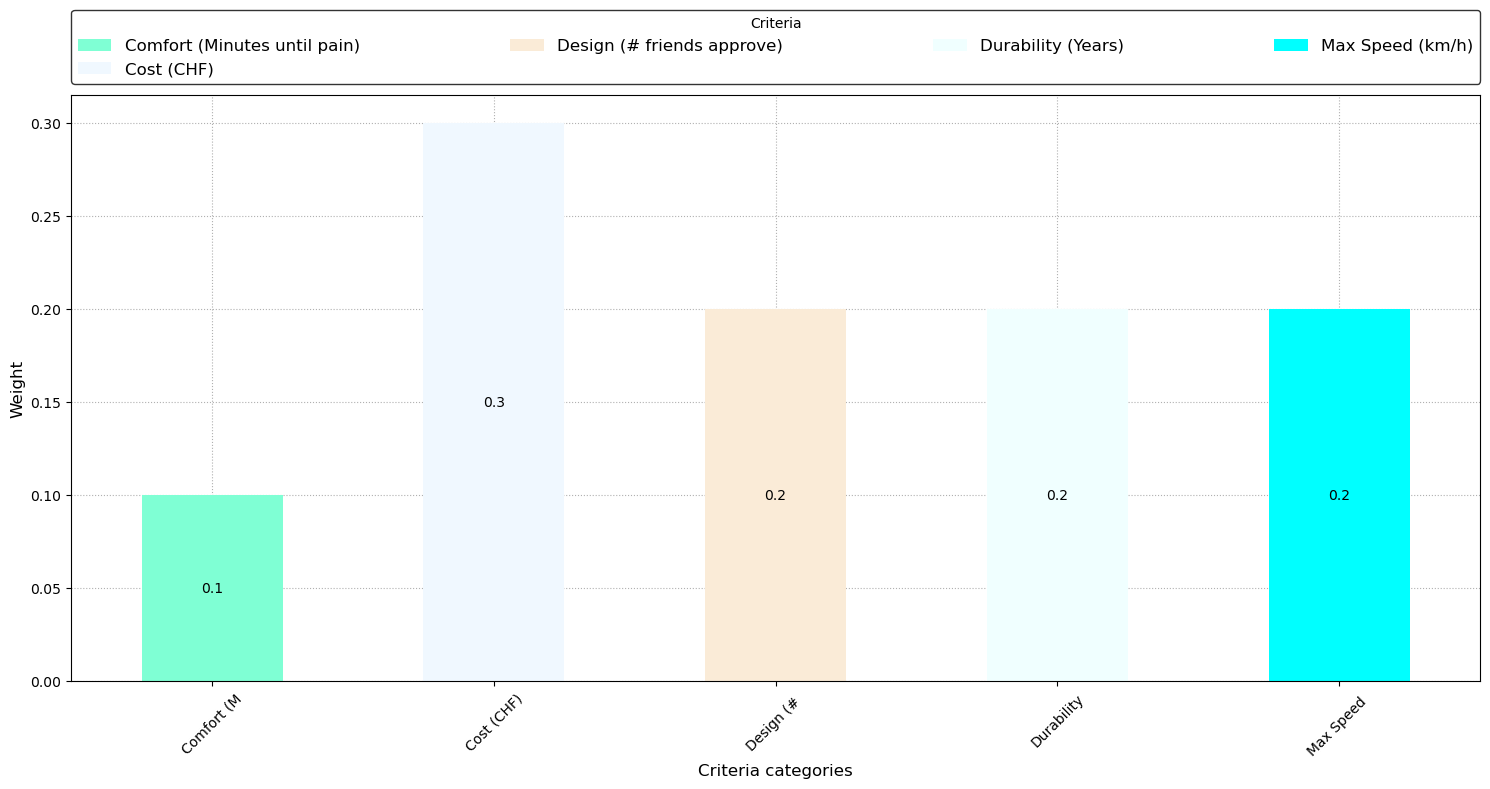

In [48]:
import pandas as pd
import tabulate as tb

# *************** User-modifiable parameters ***************

# Define the columns for alternatives and criteria
alt_cols = ["Bike"]
crit_cols = ["Cost (CHF)", "Design (# friends approve)", "Max Speed (km/h)", "Comfort (Minutes until pain)", "Durability (Years)"]

# Define weights 
weights = {
    "Cost (CHF)": 0.30,
    "Design (# friends approve)": 0.20,
    "Max Speed (km/h)": 0.20,
    "Comfort (Minutes until pain)": 0.10,
    "Durability (Years)": 0.20
}

# Define the objectives
objectives = {
    "Cost (CHF)": -1,  # Minimize
    "Design (# friends approve)": 1,  # Maximize
    "Max Speed (km/h)": 1,  # Maximize
    "Comfort (Minutes until pain)": 1,  # Maximize
    "Durability (Years)": 1  # Maximize
}

# Define the group columns
group_cols = ["Terrain"]

# Define the group weights
group_weights = {
    "Terrain": {
        "Flat": 0.5,
        "Hilly": 0.3,
        "Mountainous": 0.2
    }
}

# Define the uncertainty columns
unc_cols = []

# *************** End of user-modifiable parameters ***************

# Sample DataFrame to simulate the decision matrix
data = {
    "Bike": ["Bike A", "Bike A", "Bike A", "Bike B", "Bike B", "Bike B", "Bike C", "Bike C", "Bike C", "Bike D", "Bike D", "Bike D", "Bike E", "Bike E", "Bike E"],
    "Cost (CHF)": [500, 500, 500, 700, 700, 700, 450, 450, 450, 650, 650, 650, 800, 800, 800],
    "Design (# friends approve)": [7, 7, 7, 6, 6, 6, 8, 8, 8, 5, 5, 5, 9, 9, 9],
    "Max Speed (km/h)": [25, 20, 15, 28, 23, 18, 22, 17, 12, 27, 22, 17, 30, 25, 20],
    "Comfort (Minutes until pain)": [30, 25, 20, 45, 40, 35, 35, 30, 25, 50, 45, 40, 40, 35, 30],
    "Durability (Years)": [5, 4, 3, 4, 3, 2, 6, 5, 4, 5, 4, 3, 7, 6, 5],
    "Terrain": ["Flat", "Hilly", "Mountainous"] * 5
}

df = pd.DataFrame(data)

# Generate the decision matrix – Initialize the decision matrix object
dm = DecisionMatrix(
    metrics_df=df,
    objectives=objectives,
    alt_cols=alt_cols,
    crit_cols=crit_cols,
    weights=weights,
    group_cols=group_cols,
    group_weights=group_weights,
    unc_cols=unc_cols
)

# Display the decision matrix
print('The decision matrix:')
print(tb.tabulate(dm.dm_df, headers='keys', tablefmt='pretty'))
print('')

# Print the criteria DataFrame
print('The criteria DataFrame:')
print(tb.tabulate(dm.crit_df, headers='keys', tablefmt='pretty'))
print('')

# Print the categorized criteria DataFrame
print('The categorized criteria DataFrame:')
print(tb.tabulate(dm.cat_crit_df, headers='keys', tablefmt='pretty'))
print('')

# Print the alternatives DataFrame
print('The alternatives DataFrame:')
print(tb.tabulate(dm.alternatives_df, headers='keys', tablefmt='pretty'))
print('')

# Print the groups DataFrame
print('The groups DataFrame:')
print(tb.tabulate(dm.groups_df, headers='keys', tablefmt='pretty'))
print('')

# Print the group weights
print('The group weights:')
print(dm.group_weights)

# Plot the criteria
dm.plot_criteria(group_by_category=True)


### Try the pivot

The pivoted and reweighted decision matrix:
+---+----------------+--------+------------+----------------------------+-----------------------+------------------------+------------------------------+-----------------------------------+------------------------------------+------------------------------------------+-------------------------+--------------------------+--------------------------------+
|   | Alternative ID |  Bike  | Cost (CHF) | Design (# friends approve) | Max Speed (km/h)_Flat | Max Speed (km/h)_Hilly | Max Speed (km/h)_Mountainous | Comfort (Minutes until pain)_Flat | Comfort (Minutes until pain)_Hilly | Comfort (Minutes until pain)_Mountainous | Durability (Years)_Flat | Durability (Years)_Hilly | Durability (Years)_Mountainous |
+---+----------------+--------+------------+----------------------------+-----------------------+------------------------+------------------------------+-----------------------------------+------------------------------------+------------------

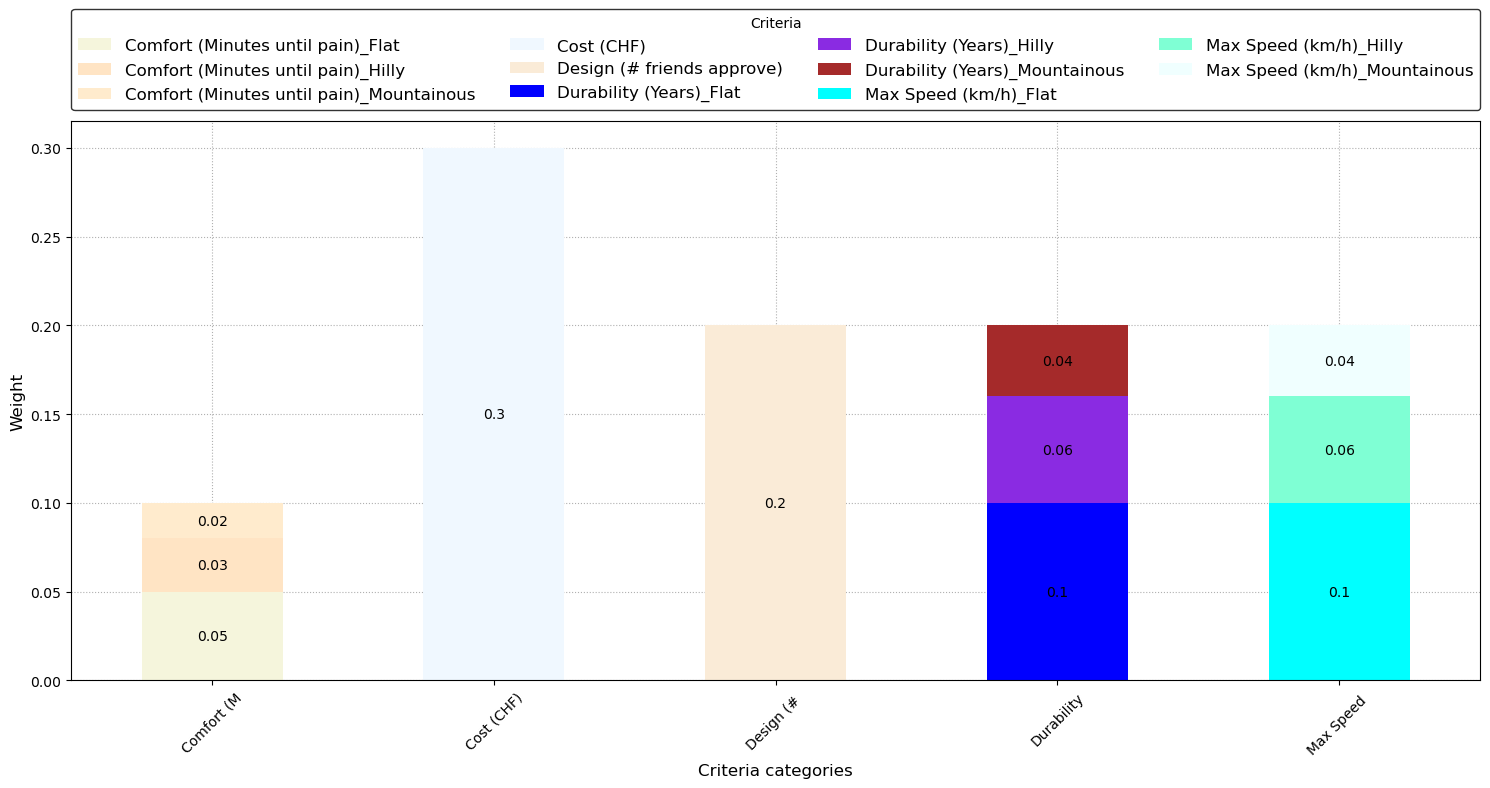

In [46]:

# Define the pivot column
piv_col = "Terrain"

# Pivot and reweight the criteria based on the specified pivot column
dm_grouped = dm.pivot_and_reweight_criteria(piv_col)

# Display the pivoted and reweighted decision matrix
print('The pivoted and reweighted decision matrix:')
print(tb.tabulate(dm_grouped.dm_df, headers='keys', tablefmt='pretty'))
print('')

# plot the criteria
dm_grouped.plot_criteria(group_by_category=True)




In [68]:
class DecisionMatrix:
    def __init__(
        self,
        metrics_df: pd.DataFrame,
        objectives: Dict[str, int],
        alt_cols: List[str],
        crit_cols: List[str],
        weights: Optional[Dict[str, float]] = None,
        group_cols: Optional[List[str]] = [],
        group_weights: Optional[Dict[str, float]] = None,
        unc_cols: Optional[List[str]] = [],
        crit_cats: Optional[Dict[str, List[str]]] = None
    ):
        """
        Initialize the DecisionMatrix object.

        Parameters:
        - metrics_df : pd.DataFrame
            DataFrame containing metrics data.
        - objectives : Dict[str, int]
            Dictionary mapping objectives to their values.
        - alt_cols : List[str]
            List of alternative columns.
        - crit_cols : List[str]
            List of criteria columns.
        - weights : Dict[str, float], optional
            Dictionary of criteria weights values. Defaults to an empty dictionary.
        - group_cols : List[str], optional
            List of group columns. Defaults to an empty list.
        - group_weights : Dict[str, float], optional
            Dictionary of weights for group columns. Defaults to an empty dictionary.
        - unc_cols : List[str], optional
            List of uncertainty columns. Defaults to an empty list.
        - crit_cats : Dict[str, List[str]], optional
            Dictionary of categorized criteria. Defaults to an empty dictionary.
        """
        
        # Assign input parameters to class attributes as copies
        self.metrics_df = metrics_df.copy()
        self.objectives = copy.deepcopy(objectives)
        self.alt_cols = alt_cols.copy()
        self.crit_cols = crit_cols.copy()
        self.weights = weights.copy() if weights is not None else {}
        self.group_cols = group_cols.copy() if group_cols is not None else []
        self.group_weights = group_weights.copy() if group_weights is not None else {}
        self.unc_cols = unc_cols.copy() if unc_cols is not None else []
        self.crit_cats = crit_cats.copy() if crit_cats is not None else {}

        # Initialize dataframes – Attributes to store dataframes used for calculations and organization
        self._initialize_dataframes()

        # Process initial data
        self._process_initial_data()

    # Method to initialize dataframes
    def _initialize_dataframes(self):
        self.dm_df = None # Decision matrix dataframe ( The main dataframe)
        self.alternatives_df = None # Alternatives dataframe (unique alternatives, their IDs)
        self.crit_df = None # Criteria dataframe (criteria and their weights)
        self.cat_crit_df = None # Categorized criteria dataframe (criteria and their categories)
        self.groups_df = None # Groups dataframe (if group columns are provided, otherwise None)
        self.unc_smpls_df = None # Uncertainty samples dataframe (if uncertainty columns are provided, otherwise None)

    # Method to process initial data
    def _process_initial_data(self):
        self._sort_metrics_df()                # Sort metrics_df by alternative, group, and uncertainty columns for readability in the decision matrix
        self._validate_inputs()                # Validate inputs for duplicate rows based on alternative, group, and uncertainty columns
        self._calculate_weights()              # Calculate weights for criteria and group columns if not provided
        self._prepare_criteria_dataframes()    # Prepare criteria dataframes (criteria and categorized criteria)
        self._prepare_alternatives_dataframe() # Prepare alternatives dataframe (unique alternatives)
        self._prepare_decision_matrix_dataframe() # Prepare decision matrix dataframe by merging alternatives, groups, and uncertainty samples

    # Method to sort metrics dataframe
    def _sort_metrics_df(self):
        """
        Sort the metrics DataFrame by alternative, group, and uncertainty columns.
        Sorting by alternative, group, and uncertainty columns makes the decision matrix more readable.
        """
        self.metrics_df = self.metrics_df.sort_values(by=self.alt_cols + self.group_cols + self.unc_cols)

    # Method to validate inputs
    def _validate_inputs(self):
        """
        Validate the input DataFrame for duplicate rows based on alternative, group, and uncertainty columns.
        Each alternative could only have one unique combination of group and uncertainty columns.
        """
        if self.metrics_df.duplicated(subset=self.alt_cols + self.group_cols + self.unc_cols, keep=False).any():
            raise ValueError("Duplicated rows of alt_cols, group_cols, and sample. Some alternative IDs are counted more than once for some group ID and sample ID pairs.")

    # Method to calculate weights
    def _calculate_weights(self):
        """
        Calculate weights for criteria and group columns if not provided.

        This method performs the following main tasks:
        1. Assign equal weights to criteria if not provided.
        2. Calculate and assign weights to group members if group columns are specified.
        """
        
        # Check if weights for criteria are provided
        if not self.weights:
            # Define a custom rounding function to handle precision
            def custom_round(value):
                # Determine the number of decimal places
                decimal_count = len(str(value).split(".")[1]) if "." in str(value) else 0
                # Round to a maximum of two decimal places
                decimals = 2 if decimal_count >= 2 else 1
                return round(value, decimals)
            
            # Assign equal weights to each criterion
            self.weights = {crit: custom_round(1/len(self.crit_cols)) for crit in self.crit_cols}

        # Check if there are group columns specified
        if self.group_cols:
            # Drop duplicates to identify unique groups and reset the index
            self.groups_df = self.metrics_df[self.group_cols].drop_duplicates().reset_index(drop=True)
            # Assign a unique 'Group ID' to each group
            self.groups_df.insert(0, 'Group ID', ['G' + str(idx) for idx in range(1, len(self.groups_df) + 1)])
            
            # Iterate through each group column
            for group_col in self.group_cols:
                # Create a temporary DataFrame with unique values of the group column
                temp_df = pd.DataFrame(self.metrics_df[group_col].drop_duplicates())
                # Initialize a 'Weight' column with NaN values
                temp_df['Weight'] = np.nan
                
                # Iterate through each member of the group
                for idx, member in temp_df.iterrows():
                    member_name = member[group_col]
                    # Assign provided group weight if available
                    if member_name != 'ALL' and self.group_weights and group_col in self.group_weights and isinstance(self.group_weights[group_col], dict) and member_name in self.group_weights[group_col]:
                        temp_df.at[idx, 'Weight'] = self.group_weights[group_col][member_name]
                
                # Exclude rows where the group column value is 'ALL'
                temp_df = temp_df[temp_df[group_col] != 'ALL']
                # Calculate the sum of defined weights
                sum_defined_weights = temp_df['Weight'].sum()
                # Identify members with undefined weights
                remaining_members = temp_df[temp_df['Weight'].isna()]
                remaining_count = len(remaining_members)
                
                # Distribute the remaining weight equally among members with undefined weights
                if remaining_count > 0:
                    remainder = 1 - sum_defined_weights
                    equal_weight = remainder / remaining_count
                    temp_df.loc[temp_df['Weight'].isna(), 'Weight'] = equal_weight
                
                # Update the group weights with the calculated weights
                self.group_weights[group_col] = temp_df

    # Method to prepare criteria dataframes
    def _prepare_criteria_dataframes(self):
        """
        Prepare DataFrames for criteria and categorized criteria.

        This method performs the following main tasks:
        1. Create a DataFrame for criteria with their IDs, weights, and objectives.
        2. Create a dictionary for categorized criteria if not provided.
        3. Create a DataFrame for categorized criteria and merge it with the criteria DataFrame.

        Steps:
        1. Create a DataFrame for criteria:
            - Generate criteria IDs.
            - Assign criteria weights and objectives.
        2. Check if categorized criteria are provided:
            - If not, create a default categorization where each criterion is its own category.
        3. Create a DataFrame for categorized criteria:
            - Assign category IDs.
            - Merge categorized criteria with the main criteria DataFrame.
        """

        # Step 1: Create a DataFrame for criteria
        self.crit_df = pd.DataFrame([
            {'Criteria ID': 'C' + str(idx + 1), 'Criteria': crit, 'Weight': self.weights[crit], 'Objective': self.objectives[crit]}
            for idx, crit in enumerate(self.crit_cols)
        ])

        # Step 2: Check if categorized criteria are provided
        if not self.crit_cats:
            # Create a default categorization where each criterion is its own category
            self.crit_cats = {crit: [crit] for crit in self.crit_cols}

        # Step 3: Create a DataFrame for categorized criteria
        data = [
            {'Cat ID': 'CAT' + str(idx + 1), 'Category': cat, 'Criteria': crit}
            for idx, (cat, crits) in enumerate(self.crit_cats.items())
            for crit in crits
        ]
        self.cat_crit_df = pd.DataFrame(data).merge(self.crit_df, on='Criteria')

    # Method to prepare alternatives dataframe
    def _prepare_alternatives_dataframe(self):
        """
        Prepare the alternatives DataFrame.

        This method performs the following main tasks:
        1. Check if alternative columns are provided.
        2. Create a DataFrame for unique alternatives.
        3. Assign unique IDs to each alternative.

        Steps:
        1. Check for alternative columns:
            - Raise an error if not provided.
        2. Create a DataFrame for unique alternatives:
            - Drop duplicate rows.
        3. Assign unique IDs to each alternative:
            - Insert an 'Alternative ID' column with unique IDs.
        """

        # Step 1: Check for alternative columns
        if not self.alt_cols:
            raise ValueError("No alternative column given.")

        # Step 2: Create a DataFrame for unique alternatives
        self.alternatives_df = self.metrics_df[self.alt_cols].drop_duplicates()

        # Step 3: Ensure 'Alternative ID' exists only once
        if 'Alternative ID' not in self.alternatives_df.columns:
            self.alternatives_df.insert(0, 'Alternative ID', ['A' + str(idx) for idx in range(1, len(self.alternatives_df) + 1)])

    # Method to prepare decision matrix dataframe
    def _prepare_decision_matrix_dataframe(self):
        """
        Prepare the decision matrix DataFrame by merging alternatives, groups, and uncertainty samples.

        This method performs the following main tasks:
        1. Initialize the decision matrix with the alternatives DataFrame.
        2. Merge the decision matrix with groups DataFrame if available.
        3. Merge the decision matrix with uncertainty samples DataFrame if available.
        4. Merge the decision matrix with the metrics DataFrame on specified columns.

        Steps:
        1. Initialize the decision matrix:
            - Copy the alternatives DataFrame.
        2. Merge with groups DataFrame:
            - If available, merge on a temporary '_merge' column.
        3. Merge with uncertainty samples DataFrame:
            - If available, merge on a temporary '_merge' column.
        4. Finalize the decision matrix:
            - Drop the temporary '_merge' column.
            - Merge with the metrics DataFrame on alternative, group, and uncertainty columns.
        """

        # Step 1: Initialize the decision matrix
        self.dm_df = self.alternatives_df.copy()
        self.dm_df['_merge'] = 1

        # Step 2: Merge with groups DataFrame if available
        if isinstance(self.groups_df, pd.DataFrame):
            self.groups_df['_merge'] = 1
            self.dm_df = self.dm_df.merge(self.groups_df, on='_merge')
            self.groups_df = self.groups_df.drop('_merge', axis=1)

        # Step 3: Merge with uncertainty samples DataFrame if available
        if isinstance(self.unc_smpls_df, pd.DataFrame):
            self.unc_smpls_df['_merge'] = 1
            self.dm_df = self.dm_df.merge(self.unc_smpls_df, on='_merge')
            self.unc_smpls_df = self.unc_smpls_df.drop('_merge', axis=1)

        # Step 4: Finalize the decision matrix
        self.dm_df = self.dm_df.drop('_merge', axis=1)
        self.dm_df = pd.merge(self.dm_df, self.metrics_df[self.alt_cols + self.group_cols + self.unc_cols + self.crit_cols], on=self.alt_cols + self.group_cols + self.unc_cols, how='left')


In [70]:
import pandas as pd

# Define example data with Terrain and Weather
data = {
    'Alternative': ['A1', 'A1', 'A1', 'A1', 'A1', 'A1', 'A1', 'A1', 'A1',
                    'A2', 'A2', 'A2', 'A2', 'A2', 'A2', 'A2', 'A2', 'A2',
                    'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3'],
    'Terrain': ['Flat', 'Flat', 'Flat', 'Hilly', 'Hilly', 'Hilly', 'Mountainous', 'Mountainous', 'Mountainous',
                'Flat', 'Flat', 'Flat', 'Hilly', 'Hilly', 'Hilly', 'Mountainous', 'Mountainous', 'Mountainous',
                'Flat', 'Flat', 'Flat', 'Hilly', 'Hilly', 'Hilly', 'Mountainous', 'Mountainous', 'Mountainous'],
    'Weather': ['S1', 'S2', 'S3', 'S1', 'S2', 'S3', 'S1', 'S2', 'S3',
                'S1', 'S2', 'S3', 'S1', 'S2', 'S3', 'S1', 'S2', 'S3',
                'S1', 'S2', 'S3', 'S1', 'S2', 'S3', 'S1', 'S2', 'S3'],
    'Cost (CHF)': [500, 510, 520, 450, 460, 470, 550, 560, 570,
                   450, 460, 470, 400, 410, 420, 500, 510, 520,
                   550, 560, 570, 500, 510, 520, 600, 610, 620],
    'Design (# friends approve)': [10, 11, 12, 10, 11, 12, 10, 11, 12,
                                   9, 8, 7, 9, 8, 7, 9, 8, 7,
                                   13, 14, 15, 13, 14, 15, 13, 14, 15],
    'Max Speed (km/h)': [25, 26, 27, 28, 29, 30, 31, 32, 33,
                         25, 26, 27, 28, 29, 30, 31, 32, 33,
                         25, 26, 27, 28, 29, 30, 31, 32, 33],
    'Comfort (Minutes until pain)': [30, 35, 40, 45, 50, 55, 60, 65, 70,
                                     30, 35, 40, 45, 50, 55, 60, 65, 70,
                                     30, 35, 40, 45, 50, 55, 60, 65, 70],
    'Durability (Years)': [5, 6, 7, 8, 9, 10, 11, 12, 13,
                           5, 6, 7, 8, 9, 10, 11, 12, 13,
                           5, 6, 7, 8, 9, 10, 11, 12, 13]
}

# Create DataFrame
dm_df = pd.DataFrame(data)

# Define additional parameters
objectives = {
    "Cost (CHF)": -1,
    "Design (# friends approve)": 1,
    "Max Speed (km/h)": 1,
    "Comfort (Minutes until pain)": 1,
    "Durability (Years)": 1
}

weights = {
    "Cost (CHF)": 0.30,
    "Design (# friends approve)": 0.20,
    "Max Speed (km/h)": 0.20,
    "Comfort (Minutes until pain)": 0.10,
    "Durability (Years)": 0.20
}

group_cols = ["Terrain"]
group_weights = {
    "Terrain": {
        "Flat": 0.5,
        "Hilly": 0.3,
        "Mountainous": 0.2
    }
}

alt_cols = ["Alternative"]
crit_cols = ["Cost (CHF)", "Design (# friends approve)", "Max Speed (km/h)", "Comfort (Minutes until pain)", "Durability (Years)"]
unc_cols = ["Weather"]

# Create the DecisionMatrix instance
dm = DecisionMatrix(
    metrics_df=dm_df,
    objectives=objectives,
    alt_cols=alt_cols,
    crit_cols=crit_cols,
    weights=weights,
    group_cols=group_cols,
    group_weights=group_weights,
    unc_cols=unc_cols
)

# Print the DataFrame to ensure it's correctly set up
print(dm.dm_df)


KeyError: 'Weather'

### Groups – Bike performance at differnt Places Example City, Rural, ...

### UNcertainy - ...

In [71]:
from DecisionMatrix import DecisionMatrix

ImportError: attempted relative import with no known parent package